In [18]:
%matplotlib inline

from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import seaborn as sns

In [3]:
all_files = [fname for fname in os.listdir('data') if fname[-4:] == "json" and '2015-01' in fname]

In [4]:
all_files[0]

'2015-01-13-2.json'

In [6]:
# load all events
events = []
for i, fname in enumerate(all_files[:5]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        events.append(json.loads(line))

0 out of 720 files loaded


In [7]:
types = [e['type'] for e in events]
type_counts = Counter(types)
df = pd.DataFrame.from_dict(type_counts, orient='index')
df.columns= ["Range"]

In [7]:
plt.style.use('ggplot')
sns.set_context("poster")

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


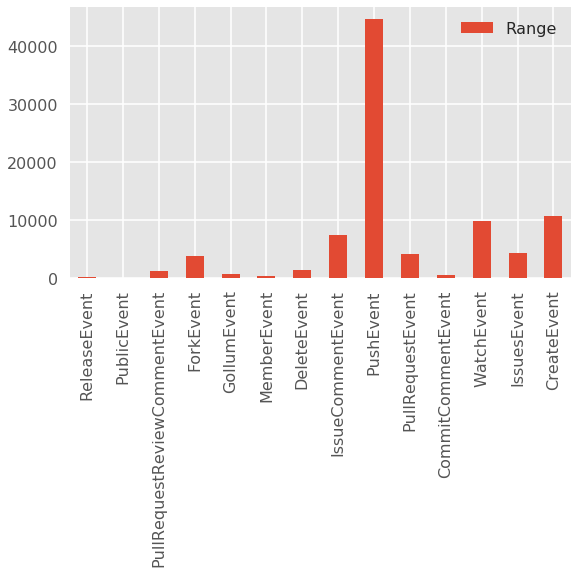

In [8]:
df.plot(kind='bar', figsize=(9,5))
sns.despine()
plt.show()

In [9]:
actors = [e['actor']['login'] for e in events]
actor_count = Counter(actors)
over5 = np.sum([1 if v >=5 else 0 for v in actor_count.values()])
count_count = Counter(actor_count.values())

89883 38801 3780


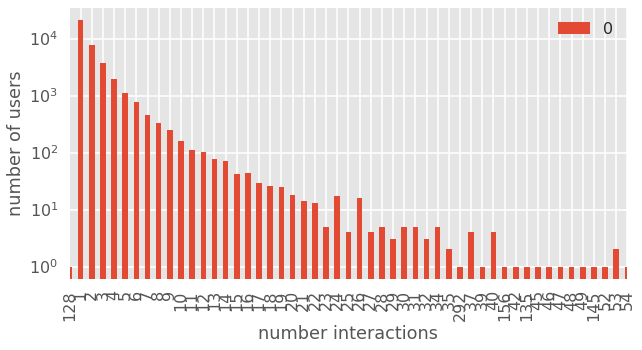

In [10]:
print len(actors), len(set(actors)), over5
df = pd.DataFrame.from_dict(count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number interactions")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Calculate common keys between all events

In [8]:
common_set = set(events[0].keys())
for i in range(1000):
    common_set = common_set & set(events[i].keys())
common_set

{u'actor', u'created_at', u'id', u'payload', u'public', u'repo', u'type'}

## Look into number of repos

In [12]:
repos = [e['repo']['name'] for e in events]
repo_count = Counter(repos)
df = pd.DataFrame.from_dict(repo_count, orient='index')
over5repos = np.sum([1 if v >=5 else 0 for v in repo_count.values()])
print len(repos), len(set(repos)), over5repos


89883 41348 3401


In [13]:
print len(df[df[0]>100]), "with over 100 commits in the files"
df[df[0]>100].sort_values(0, ascending=False).head(15)

8 with over 100 commits in the files


,0
KenanSulayman/heartbeat,386
rust-lang/rust,191
apache/spark,166
greatfire/wiki,161
sakai-mirror/melete,150
qdm/qdm.github.io,145
YGGDRASIL-STUDIO/Discouraged-Workers,128
zephiK/android_frameworks_base,113


## Repos per person

In [14]:
actor_repo = {a:set() for a in actors}

In [15]:
for e in events: 
    actor_repo[e['actor']['login']].add(e['repo']['name'])


In [16]:
a_r_count = {a:len(actor_repo[a]) for a in actors}

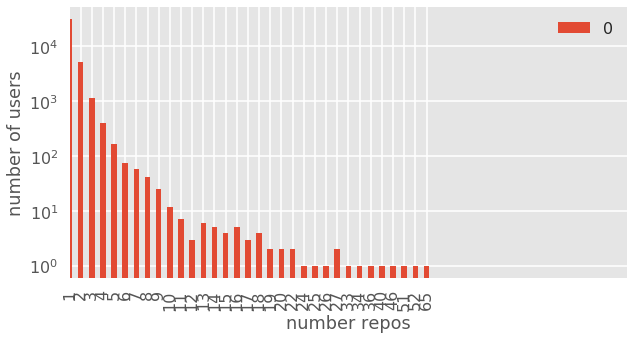

In [17]:
a_r_count_count = Counter(a_r_count.values())
df = pd.DataFrame.from_dict(a_r_count_count, orient='index')

df.plot(kind='bar', logy=True, figsize=(10,5))
plt.xlabel("number repos")
plt.ylabel("number of users")
plt.xlim([0,50])
plt.show()

## Get statistics over all data

In [18]:
# load all events
# events = []
repo_commits = Counter()
repo_users = Counter()
repo_users_names = Counter()
user_commits = Counter()

for i, fname in enumerate(all_files[:20]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        if e['type'] == 'PushEvent':
            num_comms = events[0]['payload']['distinct_size']
            repo_name = e['repo']['name']
            actor_name = e['actor']['login']
            repo_commits[repo_name] += num_comms
            user_commits[actor_name] += num_comms
            if repo_users_names[repo_name]:
                repo_users_names[repo_name].add(actor_name)
            else:
                repo_users_names[repo_name] = set([actor_name])
            repo_users[repo_name] = len(repo_users_names[repo_name])
            
            #print num_comms, events[0]['payload']            
        

0 out of 720 files loaded


IOError: [Errno 2] No such file or directory: 'data/2015-01-13-2.json'

In [22]:
def write(outfile, dictfile):
    out = open(outfile, "w")
    items = [(v, k) for k, v in dictfile.iteritems()]
    items.sort()
    for v, k in items:
        print >> out, k, v
    out.close()

In [25]:
write("repo_commits.txt", repo_commits)
write("repo_users.txt", repo_users)
write("repo_users_names.txt", repo_users_names)


In [ ]:
import operator

In [34]:
sorted(repo_users.iteritems(), key=operator.itemgetter(1), reverse=True)[:5]

[(u'ncss-2015-group-4/trivia', 12),
 (u'Chantilly612Code/612-2015', 11),
 (u'sagemath/grant-europe', 11),
 (u'dava/dava.framework', 9),
 (u'edx/edx-platform', 9)]

In [26]:
for e in events:
    print e['payload']
    break

{u'size': 1, u'head': u'bd869e86cb714f82e9892c22ef61b3dec0123314', u'commits': [{u'distinct': True, u'sha': u'bd869e86cb714f82e9892c22ef61b3dec0123314', u'message': u'IMGs', u'url': u'https://api.github.com/repos/garethnunns/MyHRSFC-CMS/commits/bd869e86cb714f82e9892c22ef61b3dec0123314', u'author': {u'email': u'5c57adbb9b8435a23d0b23c9e09b035d6f202eb7@gmail.com', u'name': u'Gareth Nunns'}}], u'distinct_size': 1, u'push_id': 542821867, u'ref': u'refs/heads/master', u'before': u'dc7dda25564258f7e22bf3846a81a52cc909c254'}


## Simplest possible model: HMM with only user type of actions over time per repo

In [9]:
from collections import defaultdict

In [14]:
#user_take_into_account = [u for u,k in user_commits.iteritems() if k > 10]
user_last_repo = Counter()

In [11]:
etypes = set(types)
type_enc = {}
for i, v in enumerate(etypes):
    type_enc[v+"_same"] = i
typenum = len(etypes)
for i, v in enumerate(etypes):
    type_enc[v+"_diff"] = i + typenum


In [13]:
print type_enc

{u'MemberEvent_diff': 19, u'IssuesEvent_same': 12, u'DeleteEvent_same': 6, u'IssuesEvent_diff': 26, u'PullRequestReviewCommentEvent_diff': 16, u'CreateEvent_diff': 27, u'DeleteEvent_diff': 20, u'ReleaseEvent_diff': 14, u'CreateEvent_same': 13, u'CommitCommentEvent_same': 10, u'ReleaseEvent_same': 0, u'PublicEvent_diff': 15, u'WatchEvent_same': 11, u'IssueCommentEvent_diff': 21, u'PullRequestReviewCommentEvent_same': 2, u'PullRequestEvent_diff': 23, u'PublicEvent_same': 1, u'ForkEvent_diff': 17, u'GollumEvent_diff': 18, u'CommitCommentEvent_diff': 24, u'GollumEvent_same': 4, u'PushEvent_same': 8, u'PullRequestEvent_same': 9, u'ForkEvent_same': 3, u'WatchEvent_diff': 25, u'IssueCommentEvent_same': 7, u'MemberEvent_same': 5, u'PushEvent_diff': 22}


In [16]:
#dataset = {u:[] for u in user_take_into_account}
dataset = defaultdict(list)

In [17]:
for i, fname in enumerate(all_files[:1]):
    if i%10 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("data", fname), 'r'):
        e = json.loads(line)
        actor_name = e['actor']['login']
        #if actor_name in user_take_into_account:
        ctype = e['type']
        repo_name = e['repo']['name']
        suffix = ""
        if user_last_repo[actor_name] == repo_name:
            suffix = "_same"
        else: 
            suffix = "_diff"
        user_last_repo[actor_name] = repo_name
        dataset[actor_name].append(type_enc[ctype+suffix])

0 out of 720 files loaded


[]

In [71]:
import cPickle as pkl

In [72]:
with open('dataset.pkl', 'wb') as f:
    pkl.dump(dataset,f)

In [82]:
data_lengths = [k for k, v in dataset.iteritems() if 50000 > len(v) > 10000]
data_lengths

[u'mirror-updates',
 u'qdm',
 u'pluginmirror-worker',
 u'KenanSulayman',
 u'greatfire',
 u'coveralls']

(0, 150)

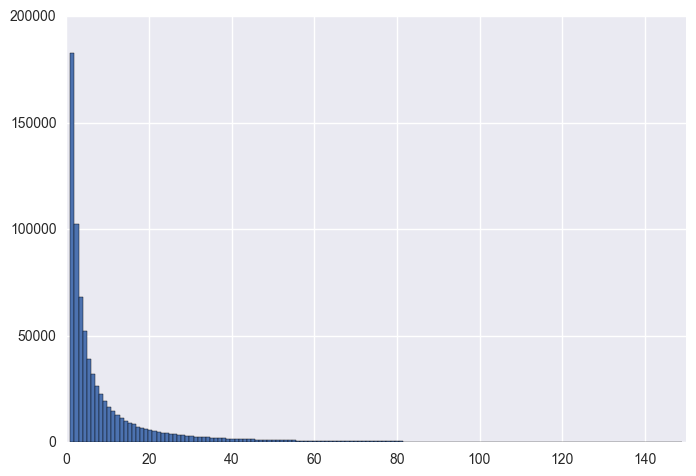

In [77]:
plt.hist(data_lengths, bins=150)
plt.xlim([0,150])

In [83]:
type_enc

{u'CommitCommentEvent_diff': 24,
 u'CommitCommentEvent_same': 10,
 u'CreateEvent_diff': 27,
 u'CreateEvent_same': 13,
 u'DeleteEvent_diff': 23,
 u'DeleteEvent_same': 9,
 u'ForkEvent_diff': 17,
 u'ForkEvent_same': 3,
 u'GollumEvent_diff': 18,
 u'GollumEvent_same': 4,
 u'IssueCommentEvent_diff': 21,
 u'IssueCommentEvent_same': 7,
 u'IssuesEvent_diff': 26,
 u'IssuesEvent_same': 12,
 u'MemberEvent_diff': 14,
 u'MemberEvent_same': 0,
 u'PublicEvent_diff': 15,
 u'PublicEvent_same': 1,
 u'PullRequestEvent_diff': 20,
 u'PullRequestEvent_same': 6,
 u'PullRequestReviewCommentEvent_diff': 16,
 u'PullRequestReviewCommentEvent_same': 2,
 u'PushEvent_diff': 22,
 u'PushEvent_same': 8,
 u'ReleaseEvent_diff': 19,
 u'ReleaseEvent_same': 5,
 u'WatchEvent_diff': 25,
 u'WatchEvent_same': 11}

In [86]:
write("type_encoding", type_enc )

In [92]:
reverse_enc = {v:k for k,v in type_enc.iteritems()}
sorted_list_enc = [str(reverse_enc[i]) for i in  xrange(max(reverse_enc.keys())+1)]

In [93]:
sorted_list_enc

['MemberEvent_same',
 'PublicEvent_same',
 'PullRequestReviewCommentEvent_same',
 'ForkEvent_same',
 'GollumEvent_same',
 'ReleaseEvent_same',
 'PullRequestEvent_same',
 'IssueCommentEvent_same',
 'PushEvent_same',
 'DeleteEvent_same',
 'CommitCommentEvent_same',
 'WatchEvent_same',
 'IssuesEvent_same',
 'CreateEvent_same',
 'MemberEvent_diff',
 'PublicEvent_diff',
 'PullRequestReviewCommentEvent_diff',
 'ForkEvent_diff',
 'GollumEvent_diff',
 'ReleaseEvent_diff',
 'PullRequestEvent_diff',
 'IssueCommentEvent_diff',
 'PushEvent_diff',
 'DeleteEvent_diff',
 'CommitCommentEvent_diff',
 'WatchEvent_diff',
 'IssuesEvent_diff',
 'CreateEvent_diff']

In [91]:
np.arange(0,29)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [26]:
for i, fname in enumerate(all_files[:20]):
    if i%1 == 0:
            print i, "out of", len(all_files), "files loaded"
    for line in open(os.path.join("../data", fname), 'r'):
        e = json.loads(line)
        if e['type'] == 'PushEvent':
            import pprint
            pprint.pprint(e)
            break
    break

0 out of 720 files loaded
{u'actor': {u'avatar_url': u'https://avatars.githubusercontent.com/u/4368625?',
            u'gravatar_id': u'',
            u'id': 4368625,
            u'login': u'davidbrough1',
            u'url': u'https://api.github.com/users/davidbrough1'},
 u'created_at': u'2015-01-13T02:00:00Z',
 u'id': u'2508406479',
 u'payload': {u'before': u'82b803d932f548142d27b51fdf59b9f978313599',
              u'commits': [{u'author': {u'email': u'b6e3ba5e2952d42c90bf0fe913e6e3f7c7c852bb@gmail.com',
                                        u'name': u'David Brough'},
                            u'distinct': True,
                            u'message': u'Update about.md',
                            u'sha': u'c64722517781bede496d920e55cad7c7f7b24aec',
                            u'url': u'https://api.github.com/repos/davidbrough1/research-blog/commits/c64722517781bede496d920e55cad7c7f7b24aec'}],
              u'distinct_size': 1,
              u'head': u'c64722517781bede496d920e55